# Detecting Anomalies using Heterogeneous GNNs

## Exploring the CIDDS-001 dataset

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Harsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


The following download can be extremely slow. It is safer to perform it outside of this notebook.

In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://www.hs-coburg.de/fileadmin/hscoburg/WISENT-CIDDS-001.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData
from torch.nn import functional as F
from torch.optim import Adam
from torch import nn
import torch

In [4]:
df = pd.read_csv("CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv")
df

C:\Users\Harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,445,192.168.220.16,58844.0,1,108,1,.AP...,0,normal,---,---,---
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,48888,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,58844,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,TCP,192.168.200.8,62605,EXT_SERVER,8082.0,2,319,1,.AP...,0,normal,---,---,---
8451516,2017-03-21 23:59:57.037,0.000,TCP,10179_174,443,192.168.210.5,51433.0,1,54,1,.A....,32,normal,---,---,---
8451517,2017-03-21 23:59:56.920,0.000,TCP,192.168.210.5,51433,10179_174,443.0,1,55,1,.A....,0,normal,---,---,---
8451518,2017-03-21 23:59:58.299,0.000,TCP,192.168.100.5,445,192.168.220.6,56281.0,1,108,1,.AP...,0,normal,---,---,---


In [5]:
df = df.drop(columns=['Src Pt', 'Dst Pt', 'Flows', 'Tos', 'class', 'attackID', 'attackDescription'])
df['attackType'] = df['attackType'].replace('---', 'benign')
df['Date first seen'] = pd.to_datetime(df['Date first seen'])
df

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign
...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,TCP,192.168.200.8,EXT_SERVER,2,319,.AP...,benign
8451516,2017-03-21 23:59:57.037,0.000,TCP,10179_174,192.168.210.5,1,54,.A....,benign
8451517,2017-03-21 23:59:56.920,0.000,TCP,192.168.210.5,10179_174,1,55,.A....,benign
8451518,2017-03-21 23:59:58.299,0.000,TCP,192.168.100.5,192.168.220.6,1,108,.AP...,benign


benign        82.954273
dos           14.815406
portScan       2.171337
pingScan       0.039744
bruteForce     0.019239
Name: attackType, dtype: float64


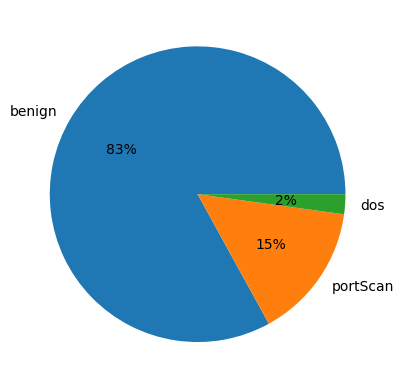

In [6]:
count_labels = df['attackType'].value_counts() / len(df) * 100
print(count_labels)
plt.pie(count_labels[:3], labels=df['attackType'].unique()[:3], autopct='%.0f%%')
plt.show()

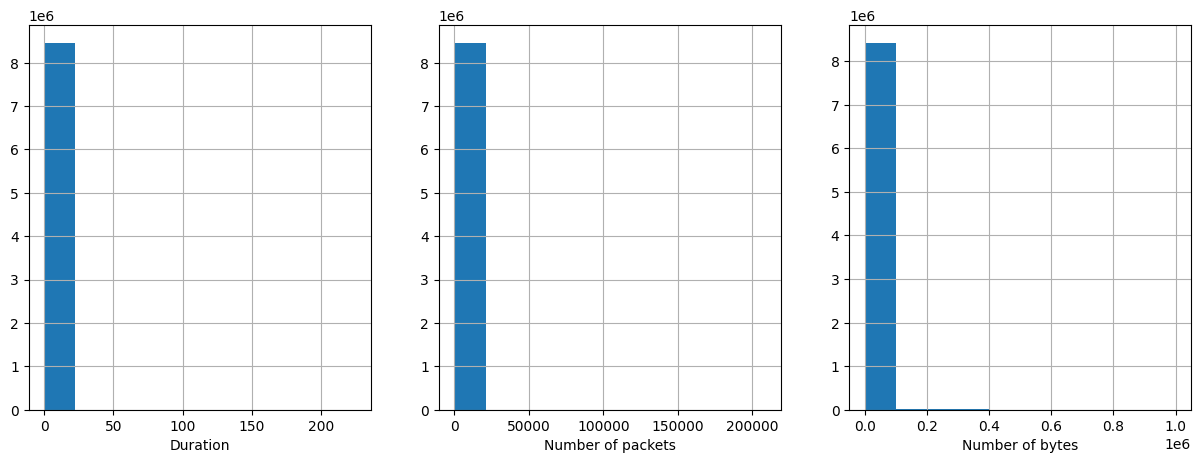

In [7]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))
df['Duration'].hist(ax=ax1)
ax1.set_xlabel("Duration")
df['Packets'].hist(ax=ax2)
ax2.set_xlabel("Number of packets")
pd.to_numeric(df['Bytes'], errors='coerce').hist(ax=ax3)
ax3.set_xlabel("Number of bytes")
plt.show()

## Preprocessing the CIDDS-001 dataset

In [8]:
df['weekday'] = df['Date first seen'].dt.weekday
df = pd.get_dummies(df, columns=['weekday']).rename(columns = {'weekday_0': 'Monday',
                                                              'weekday_1': 'Tuesday',
                                                              'weekday_2': 'Wednesday',
                                                              'weekday_3': 'Thursday',
                                                              'weekday_4': 'Friday',
                                                              'weekday_5': 'Saturday',
                                                              'weekday_6': 'Sunday',
                                                             })

df['daytime'] = (df['Date first seen'].dt.second +df['Date first seen'].dt.minute*60 + df['Date first seen'].dt.hour*60*60)/(24*60*60)

In [9]:
def one_hot_flags(input):
    return [1 if char1 == char2 else 0 for char1, char2 in zip('APRSF', input[1:])]

df = df.reset_index(drop=True)
ohe_flags = one_hot_flags(df['Flags'].to_numpy())
ohe_flags = df['Flags'].apply(one_hot_flags).to_list()
df[['ACK', 'PSH', 'RST', 'SYN', 'FIN']] = pd.DataFrame(ohe_flags, columns=['ACK', 'PSH', 'RST', 'SYN', 'FIN'])
df = df.drop(columns=['Date first seen', 'Flags'])
df

,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN
0,0.000,TCP,192.168.100.5,192.168.220.16,1,108,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
1,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
2,0.004,TCP,192.168.220.15,192.168.100.5,2,174,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
3,0.004,TCP,192.168.220.16,192.168.100.5,2,174,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
4,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,0,0,1,0,0,0,0,0.000880,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,0.248,TCP,192.168.200.8,EXT_SERVER,2,319,benign,0,1,0,0,0,0,0,0.999954,1,1,0,0,0
8451516,0.000,TCP,10179_174,192.168.210.5,1,54,benign,0,1,0,0,0,0,0,0.999965,1,0,0,0,0
8451517,0.000,TCP,192.168.210.5,10179_174,1,55,benign,0,1,0,0,0,0,0,0.999954,1,0,0,0,0
8451518,0.000,TCP,192.168.100.5,192.168.220.6,1,108,benign,0,1,0,0,0,0,0,0.999977,1,1,0,0,0


In [10]:
temp = pd.DataFrame()
temp['SrcIP'] = df['Src IP Addr'].astype(str)
temp['SrcIP'][~temp['SrcIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'
temp = temp['SrcIP'].str.split('.', expand=True).rename(columns = {2: 'ipsrc3', 3: 'ipsrc4'}).astype(int)[['ipsrc3', 'ipsrc4']]
temp['ipsrc'] = temp['ipsrc3'].apply(lambda x: format(x, "b").zfill(8)) + temp['ipsrc4'].apply(lambda x: format(x, "b").zfill(8))
df = df.join(temp['ipsrc'].str.split('', expand=True)
            .drop(columns=[0, 17])
            .rename(columns=dict(enumerate([f'ipsrc_{i}' for i in range(17)])))
            .astype('int32'))
df.head(5)

,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16
0,0.000,TCP,192.168.100.5,192.168.220.16,1,108,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
1,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
2,0.004,TCP,192.168.220.15,192.168.100.5,2,174,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1
3,0.004,TCP,192.168.220.16,192.168.100.5,2,174,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0
4,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1


In [11]:
temp = pd.DataFrame()
temp['DstIP'] = df['Dst IP Addr'].astype(str)
temp['DstIP'][~temp['DstIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'
temp = temp['DstIP'].str.split('.', expand=True).rename(columns = {2: 'ipdst3', 3: 'ipdst4'}).astype(int)[['ipdst3', 'ipdst4']]
temp['ipdst'] = temp['ipdst3'].apply(lambda x: format(x, "b").zfill(8)) \
                + temp['ipdst4'].apply(lambda x: format(x, "b").zfill(8))
df = df.join(temp['ipdst'].str.split('', expand=True)
            .drop(columns=[0, 17])
            .rename(columns=dict(enumerate([f'ipdst_{i}' for i in range(17)])))
            .astype('int32'))
df.head(5)

,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16
0,0.000,TCP,192.168.100.5,192.168.220.16,1,108,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0
1,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1
2,0.004,TCP,192.168.220.15,192.168.100.5,2,174,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
3,0.004,TCP,192.168.220.16,192.168.100.5,2,174,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
4,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1


In [12]:
m_index = df[pd.to_numeric(df['Bytes'], errors='coerce').isnull() == True].index
df['Bytes'].loc[m_index] = df['Bytes'].loc[m_index].apply(lambda x: 10e6 * float(x.strip().split()[0]))
df['Bytes'] = pd.to_numeric(df['Bytes'], errors='coerce', downcast='integer')

C:\Users\Harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\dtypes\cast.py:339: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


In [13]:
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Proto', 'attackType'])
df.head(5)

,Duration,Src IP Addr,Dst IP Addr,Packets,Bytes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16,ICMP,IGMP,TCP,UDP,benign,bruteForce,dos,pingScan,portScan
0,0.000,192.168.100.5,192.168.220.16,1,108,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0.000,192.168.100.5,192.168.220.15,1,108,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,0,0,0,0
2,0.004,192.168.220.15,192.168.100.5,2,174,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0
3,0.004,192.168.220.16,192.168.100.5,2,174,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0
4,0.000,192.168.100.5,192.168.220.15,1,108,0,0,1,0,0,0,0,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,0,0,0,0


In [14]:
labels = ['benign', 'bruteForce', 'dos', 'pingScan', 'portScan']
df_train, df_test = train_test_split(df, random_state=0, test_size=0.2, stratify=df[labels])
df_val, df_test = train_test_split(df_test, random_state=0, test_size=0.5, stratify=df_test[labels])

In [15]:
scaler = PowerTransformer()
df_train[['Duration', 'Packets', 'Bytes']] = scaler.fit_transform(df_train[['Duration', 'Packets', 'Bytes']])
df_val[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_val[['Duration', 'Packets', 'Bytes']])
df_test[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_test[['Duration', 'Packets', 'Bytes']])

In [16]:
df_train[df_train['benign'] == 1]

,Duration,Src IP Addr,Dst IP Addr,Packets,Bytes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16,ICMP,IGMP,TCP,UDP,benign,bruteForce,dos,pingScan,portScan
4632132,-0.586004,192.168.210.5,10402_46,-0.991987,-1.286741,0,0,0,0,1,0,0,0.706123,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1197644,-0.586004,DNS,192.168.200.4,-0.991987,-0.075276,0,0,1,0,0,0,0,0.643044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
8146328,-0.586004,192.168.220.14,11251_120,-0.991987,-1.007791,0,1,0,0,0,0,0,0.666296,1,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
8345249,-0.586004,10261_101,192.168.220.14,-0.991987,-1.007791,0,1,0,0,0,0,0,0.754410,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0
5474885,-0.484600,192.168.220.6,DNS,0.119968,-0.052850,1,0,0,0,0,0,0,0.383588,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642681,1.987779,10032_128,192.168.220.5,0.119968,0.086917,0,0,1,0,0,0,0,0.515069,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0
1766100,2.377145,12990_115,192.168.220.4,1.191420,1.506611,0,0,0,1,0,0,0,0.383437,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
7146759,2.154645,192.168.200.8,11062_193,0.119968,1.168069,0,1,0,0,0,0,0,0.388970,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
5818547,0.077875,192.168.220.10,10346_13,0.119968,-0.067723,1,0,0,0,0,0,0,0.453600,1,0,0,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


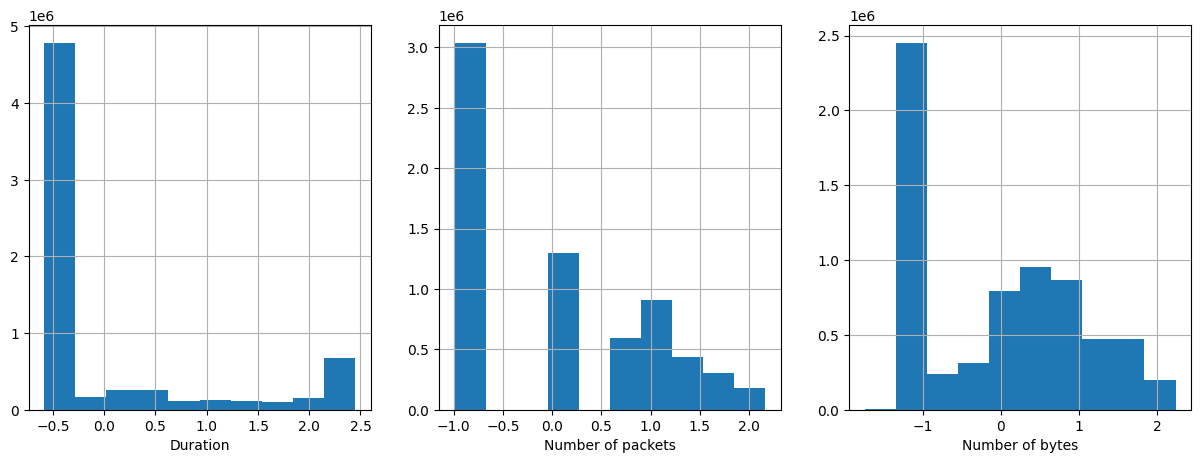

In [17]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))
df_train['Duration'].hist(ax=ax1)
ax1.set_xlabel("Duration")
df_train['Packets'].hist(ax=ax2)
ax2.set_xlabel("Number of packets")
df_train['Bytes'].hist(ax=ax3)
ax3.set_xlabel("Number of bytes")
plt.show()

## Implementing a heterogeneous GNN

In [18]:
BATCH_SIZE = 16
features_host = [f'ipsrc_{i}' for i in range(1, 17)] + [f'ipdst_{i}' for i in range(1, 17)]
features_flow = ['daytime', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Duration', 'Packets', 'Bytes', 'ACK', 'PSH', 'RST', 'SYN', 'FIN', 'ICMP ', 'IGMP ', 'TCP  ', 'UDP  ']

def get_connections(ip_map, src_ip, dst_ip):
    src1 = [ip_map[ip] for ip in src_ip]
    src2 = [ip_map[ip] for ip in dst_ip]
    src = np.column_stack((src1, src2)).flatten()
    dst = list(range(len(src_ip)))
    dst = np.column_stack((dst, dst)).flatten()
    
    return torch.Tensor([src, dst]).int(), torch.Tensor([dst, src]).int()

def create_dataloader(df, subgraph_size=1024):
    data = []
    n_subgraphs = len(df) // subgraph_size
    for i in range(1, n_subgraphs+1):
        subgraph = df[(i-1)*subgraph_size:i*subgraph_size]
        src_ip = subgraph['Src IP Addr'].to_numpy()
        dst_ip = subgraph['Dst IP Addr'].to_numpy()
        
        ip_map = {ip:index for index, ip in enumerate(np.unique(np.append(src_ip, dst_ip)))}
        host_to_flow, flow_to_host = get_connections(ip_map, src_ip, dst_ip)

        batch = HeteroData()
        batch['host'].x = torch.Tensor(subgraph[features_host].to_numpy()).float()
        batch['flow'].x = torch.Tensor(subgraph[features_flow].to_numpy()).float()
        batch['flow'].y = torch.Tensor(subgraph[labels].to_numpy()).float()
        batch['host','flow'].edge_index = host_to_flow
        batch['flow','host'].edge_index = flow_to_host
        data.append(batch)

    return DataLoader(data, batch_size=BATCH_SIZE)

train_loader = create_dataloader(df_train)
val_loader = create_dataloader(df_val)
test_loader = create_dataloader(df_test)

C:\Users\Harsh\AppData\Local\Temp\ipykernel_25764\368988823.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.Tensor([src, dst]).int(), torch.Tensor([dst, src]).int()


In [19]:
from torch_geometric.nn import Linear, HeteroConv, SAGEConv, GATConv

class HeteroGNN(torch.nn.Module):
    def __init__(self, dim_h, dim_out, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('host', 'to', 'flow'): SAGEConv((-1,-1), dim_h, add_self_loops=False),
                ('flow', 'to', 'host'): SAGEConv((-1,-1), dim_h, add_self_loops=False),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(dim_h, dim_out)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['flow'])

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGNN(dim_h=64, dim_out=5, num_layers=3).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

@torch.no_grad()
def test(loader):
    model.eval()
    y_pred = []
    y_true = []
    n_subgraphs = 0
    total_loss = 0

    for batch in loader:
        batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out, batch['flow'].y.float())
        y_pred.append(out.argmax(dim=1))
        y_true.append(batch['flow'].y.argmax(dim=1))
        n_subgraphs += BATCH_SIZE
        total_loss += float(loss) * BATCH_SIZE
        
    y_pred = torch.cat(y_pred).cpu()
    y_true = torch.cat(y_true).cpu()
    f1score = f1_score(y_true, y_pred, average='macro')

    return total_loss/n_subgraphs, f1score, y_pred, y_true


model.train()
for epoch in range(101):
    n_subgraphs = 0
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out, batch['flow'].y.float())
        loss.backward()
        optimizer.step()

        n_subgraphs += BATCH_SIZE
        total_loss += float(loss) * BATCH_SIZE

    if epoch % 10 == 0:
        val_loss, f1score, _, _ = test(val_loader)
        print(f'Epoch {epoch} | Loss: {total_loss/n_subgraphs:.4f} | Val loss: {val_loss:.4f} | Val F1-score: {f1score:.4f}')

Epoch 0 | Loss: 0.1012 | Val loss: 0.0076 | Val F1-score: 0.5933


KeyboardInterrupt: 

In [ ]:
_, _, y_pred, y_true = test(test_loader)

print(classification_report(y_true, y_pred, target_names=labels, digits=4))

In [ ]:
df_pred = pd.DataFrame([y_pred.numpy(), y_true.numpy()]).T
df_pred.columns = ['pred', 'true']
plt.pie(df_pred['true'][df_pred['pred'] != df_pred['true']].value_counts(), labels=labels, autopct='%.0f%%')

In [ ]:
matrix = confusion_matrix(y_true, y_pred)
norm_matrix = matrix / matrix.sum(axis=1) * 100

plt.imshow(norm_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)
    
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    text = f"{matrix[i,j]:,}\n{norm_matrix[i,j]:.2f}%"
    plt.text(j, i, text,
            horizontalalignment='center', verticalalignment='center',
            color='white' if matrix[i,j] >= matrix[i,:].mean() else 'black')
plt.show()